In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import DualwormFunctions as dw
import Observables as obs

%load_ext line_profiler
%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import yep

In [3]:
nst = 2048;
nsm = 256;
nips = 4;
nrps = 4;
nb = 32;
measperiod = 1;
nt = 128
nh = 1
ncores = 4
nmaxiter = 1
L = 4
J1 = -1
J2 = 1
J3 = 1
h = 0
stroutput = "JustSomeJ1{0}J2{1}J3{2}Test_step3".format(J1,J2,J3)

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = J3,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 GS''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = True, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = 'JustSomeJ1-1J21J31Test_step2_folder',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = False, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--p', type = float, default = 0.0, 
                       help = '''prob of the measuring tip flipping the spin (number between 0 and 1)''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--alternate', default = False, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.01,30],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = False, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default =True, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = False, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--correlations', default = True, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--all_correlations', default = False, action = 'store_true',
                        help = '''activate if you want to save the correlations for all non-equivalent
                        pairs of sites. Otherwise, will save central correlations.''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    args = parser.parse_args()
    return args

In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
#%%prun -s  -T prun0
#yep.start(stroutput+'.log')
%lprun -f dw.mcs_swaps [meanstat, swapst, swapsh, failedupdatesth, failedupdates] = callRunBasis()
#yep.stop()

-------------------Initialisation--------------------
./JustSomeJ1-1J21J31Test_step3_folder/backup.hkl
Lattice side size:  4
J1  -1
J2  1
J3  1
J3st  1
Couplings extracted
Hamiltonian expression (without field) computed
Number of temperatures:  128
Temperatures: [1.00000000e-02 1.06507185e-02 1.13437805e-02 1.20819413e-02
 1.28681356e-02 1.37054891e-02 1.45973306e-02 1.55472060e-02
 1.65588915e-02 1.76364092e-02 1.87840431e-02 2.00063555e-02
 2.13082062e-02 2.26947706e-02 2.41715614e-02 2.57444497e-02
 2.74196887e-02 2.92039387e-02 3.11042931e-02 3.31283071e-02
 3.52840274e-02 3.75800244e-02 4.00254262e-02 4.26299549e-02
 4.54039650e-02 4.83584851e-02 5.15052614e-02 5.48568042e-02
 5.84264381e-02 6.22283546e-02 6.62776690e-02 7.05904797e-02
 7.51839330e-02 8.00762908e-02 8.52870034e-02 9.08367867e-02
 9.67477048e-02 1.03043257e-01 1.09748473e-01 1.16890009e-01
 1.24496259e-01 1.32597461e-01 1.41225823e-01 1.50415649e-01
 1.60203474e-01 1.70628211e-01 1.81731305e-01 1.93556898e-01
 2.06

/home/jeanne/Documents/Codes/Codes_DipolarIsingModel/myopic-dual-worm/dualworm-kagome/RunBasis.py:156: UserWarning: Lowest temperature state not in the ground state after thermalisation
  warnings.warn("Lowest temperature state not in the ground state after thermalisation")


Time for mcsevolve = 0.02249957900494337
Time for tempering = 0.00544178020209074
Time for mapping to spins + computing statistics= 0.027512263506650925
Time for all measurements steps =  14.425996780395508
Energies size:  (128, 1)
RunBasis: Away from gs at t index  0
   en_states[t] =  -335.99999999999636
   ref_energy =  -335.99999999999994
Energies Checked
States Checked
Job done


In [7]:
print(failedupdatesth/(nst*nips))

[[0.00231934]
 [0.05187988]
 [0.01330566]
 [0.02331543]
 [0.05541992]
 [0.05969238]
 [0.01464844]
 [0.06384277]
 [0.03466797]
 [0.08422852]
 [0.05651855]
 [0.04333496]
 [0.03894043]
 [0.10168457]
 [0.05700684]
 [0.06872559]
 [0.07104492]
 [0.078125  ]
 [0.06494141]
 [0.08361816]
 [0.0982666 ]
 [0.10473633]
 [0.07885742]
 [0.09753418]
 [0.09033203]
 [0.10827637]
 [0.11621094]
 [0.09069824]
 [0.09460449]
 [0.10351562]
 [0.11865234]
 [0.08569336]
 [0.12438965]
 [0.08581543]
 [0.10754395]
 [0.1072998 ]
 [0.10424805]
 [0.09143066]
 [0.09545898]
 [0.10656738]
 [0.07849121]
 [0.10424805]
 [0.07202148]
 [0.07763672]
 [0.08190918]
 [0.07885742]
 [0.06567383]
 [0.08557129]
 [0.0793457 ]
 [0.06652832]
 [0.0916748 ]
 [0.11547852]
 [0.0793457 ]
 [0.08654785]
 [0.12451172]
 [0.11706543]
 [0.08679199]
 [0.10229492]
 [0.14807129]
 [0.10668945]
 [0.11621094]
 [0.12084961]
 [0.13659668]
 [0.12561035]
 [0.14794922]
 [0.15075684]
 [0.15686035]
 [0.1697998 ]
 [0.18444824]
 [0.18920898]
 [0.19494629]
 [0.20

In [8]:
print(failedupdates/(nsm*measperiod*nips))

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00390625]
 [0.03417969]
 [0.07128906]
 [0.02441406]
 [0.11035156]
 [0.12792969]
 [0.03613281]
 [0.04492188]
 [0.20117188]
 [0.04296875]
 [0.03320312]
 [0.04492188]
 [0.1171875 ]
 [0.10449219]
 [0.08496094]
 [0.08789062]
 [0.03320312]
 [0.09765625]
 [0.09082031]
 [0.09375   ]
 [0.01074219]
 [0.11816406]
 [0.03808594]
 [0.125     ]
 [0.015625  ]
 [0.14355469]
 [0.125     ]
 [0.08007812]
 [0.05957031]
 [0.125     ]
 [0.109375  ]
 [0.02636719]
 [0.05175781]
 [0.046875  ]
 [0.00097656]
 [0.01757812]
 [0.078125  ]
 [0.00488281]
 [0.01660156]
 [0.10742188]
 [0.10839844]
 [0.02832031]
 [0.02832031]
 [0.13085938]
 [0.0859375 ]
 [0.06347656]
 [0.04394531]
 [0.0546875 ]
 [0.07519531]
 [0.06445312]
 [0.08203125]
 [0.08300781]
 [0.109375  ]
 [0.13183594]
 [0.15234375]
 [0.16

In [9]:
print(4*swapst/(nrps*nsm*measperiod*nh))

[2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.         2.         2.
 2.         2.         2.         1.85546875 1.74609375 0.86328125
 1.98046875 1.7734375  1.8046875  1.96875    1.9921875  1.99609375
 1.98828125 1.9921875  1.99609375 1.98828125 1.9921875  1.99609375
 1.98828125 1.9921875  1.9921875  1.9921875  1.98828125 1.99609375
 1.98828125 1.9921875  1.9921875  1.9921875  1.9921875  1.9921875
 1.98046875 1.9921875  1.98828125 1.9921875  1.9921875  1.9921875
 1.9921875  1.98828125 1.9921875  1.98828125 1.98828125 1.97265625
 1.98046875 1.984375   1.9921875  1.984375   1.9921875  1.9921875
 1.97265625 1.9609375  1.94921875 1.92578125 1.8515625  1.8984375
 1.86328125 1.796875   1.73046875 1.78125    1.6953125  1.67578125
 1.66015625 1.6953125  1.7109375  1.6875     1.7421875  1.6953125
 1.61328125 1.60546875 1.54296875 1.51171875 1.5546875  1.56640625
 1.60546875 1.546875   1.6015625  1.53125    1.4453125  1.578125
 1.57421875 1.5664

In [10]:
print(4*swapsh/(nrps*nsm*measperiod*nt))

[0.]


In [11]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername + 'Plots' + results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [12]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh,
 stat_hfields, hfields_plots, listfunctions, sref] =\
af.LoadParameters(foldername, filenamelist)

In [13]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)


In [14]:
print(t_h_MeanE[0][0]*9*L[0]**2)
print((-2/3*J1[0] - 2/3*J2[0] + J3[0])*9*L[0]**2)

[-336.]
144.0


In [15]:
t_h_MeanE[0][0,0]

-2.333333333333305

Verifying that the low temperatures of file  backup correspond to the ground state.
Phase 1:  False
Phase 2:  False
Phase 3:  False
Phase 4:  False
Phase 5:  False
Phase 6:  False
Phase 7:  False
Phase 8:  True
Phase 9:  False
Phase 10:  False
Phase 11:  False


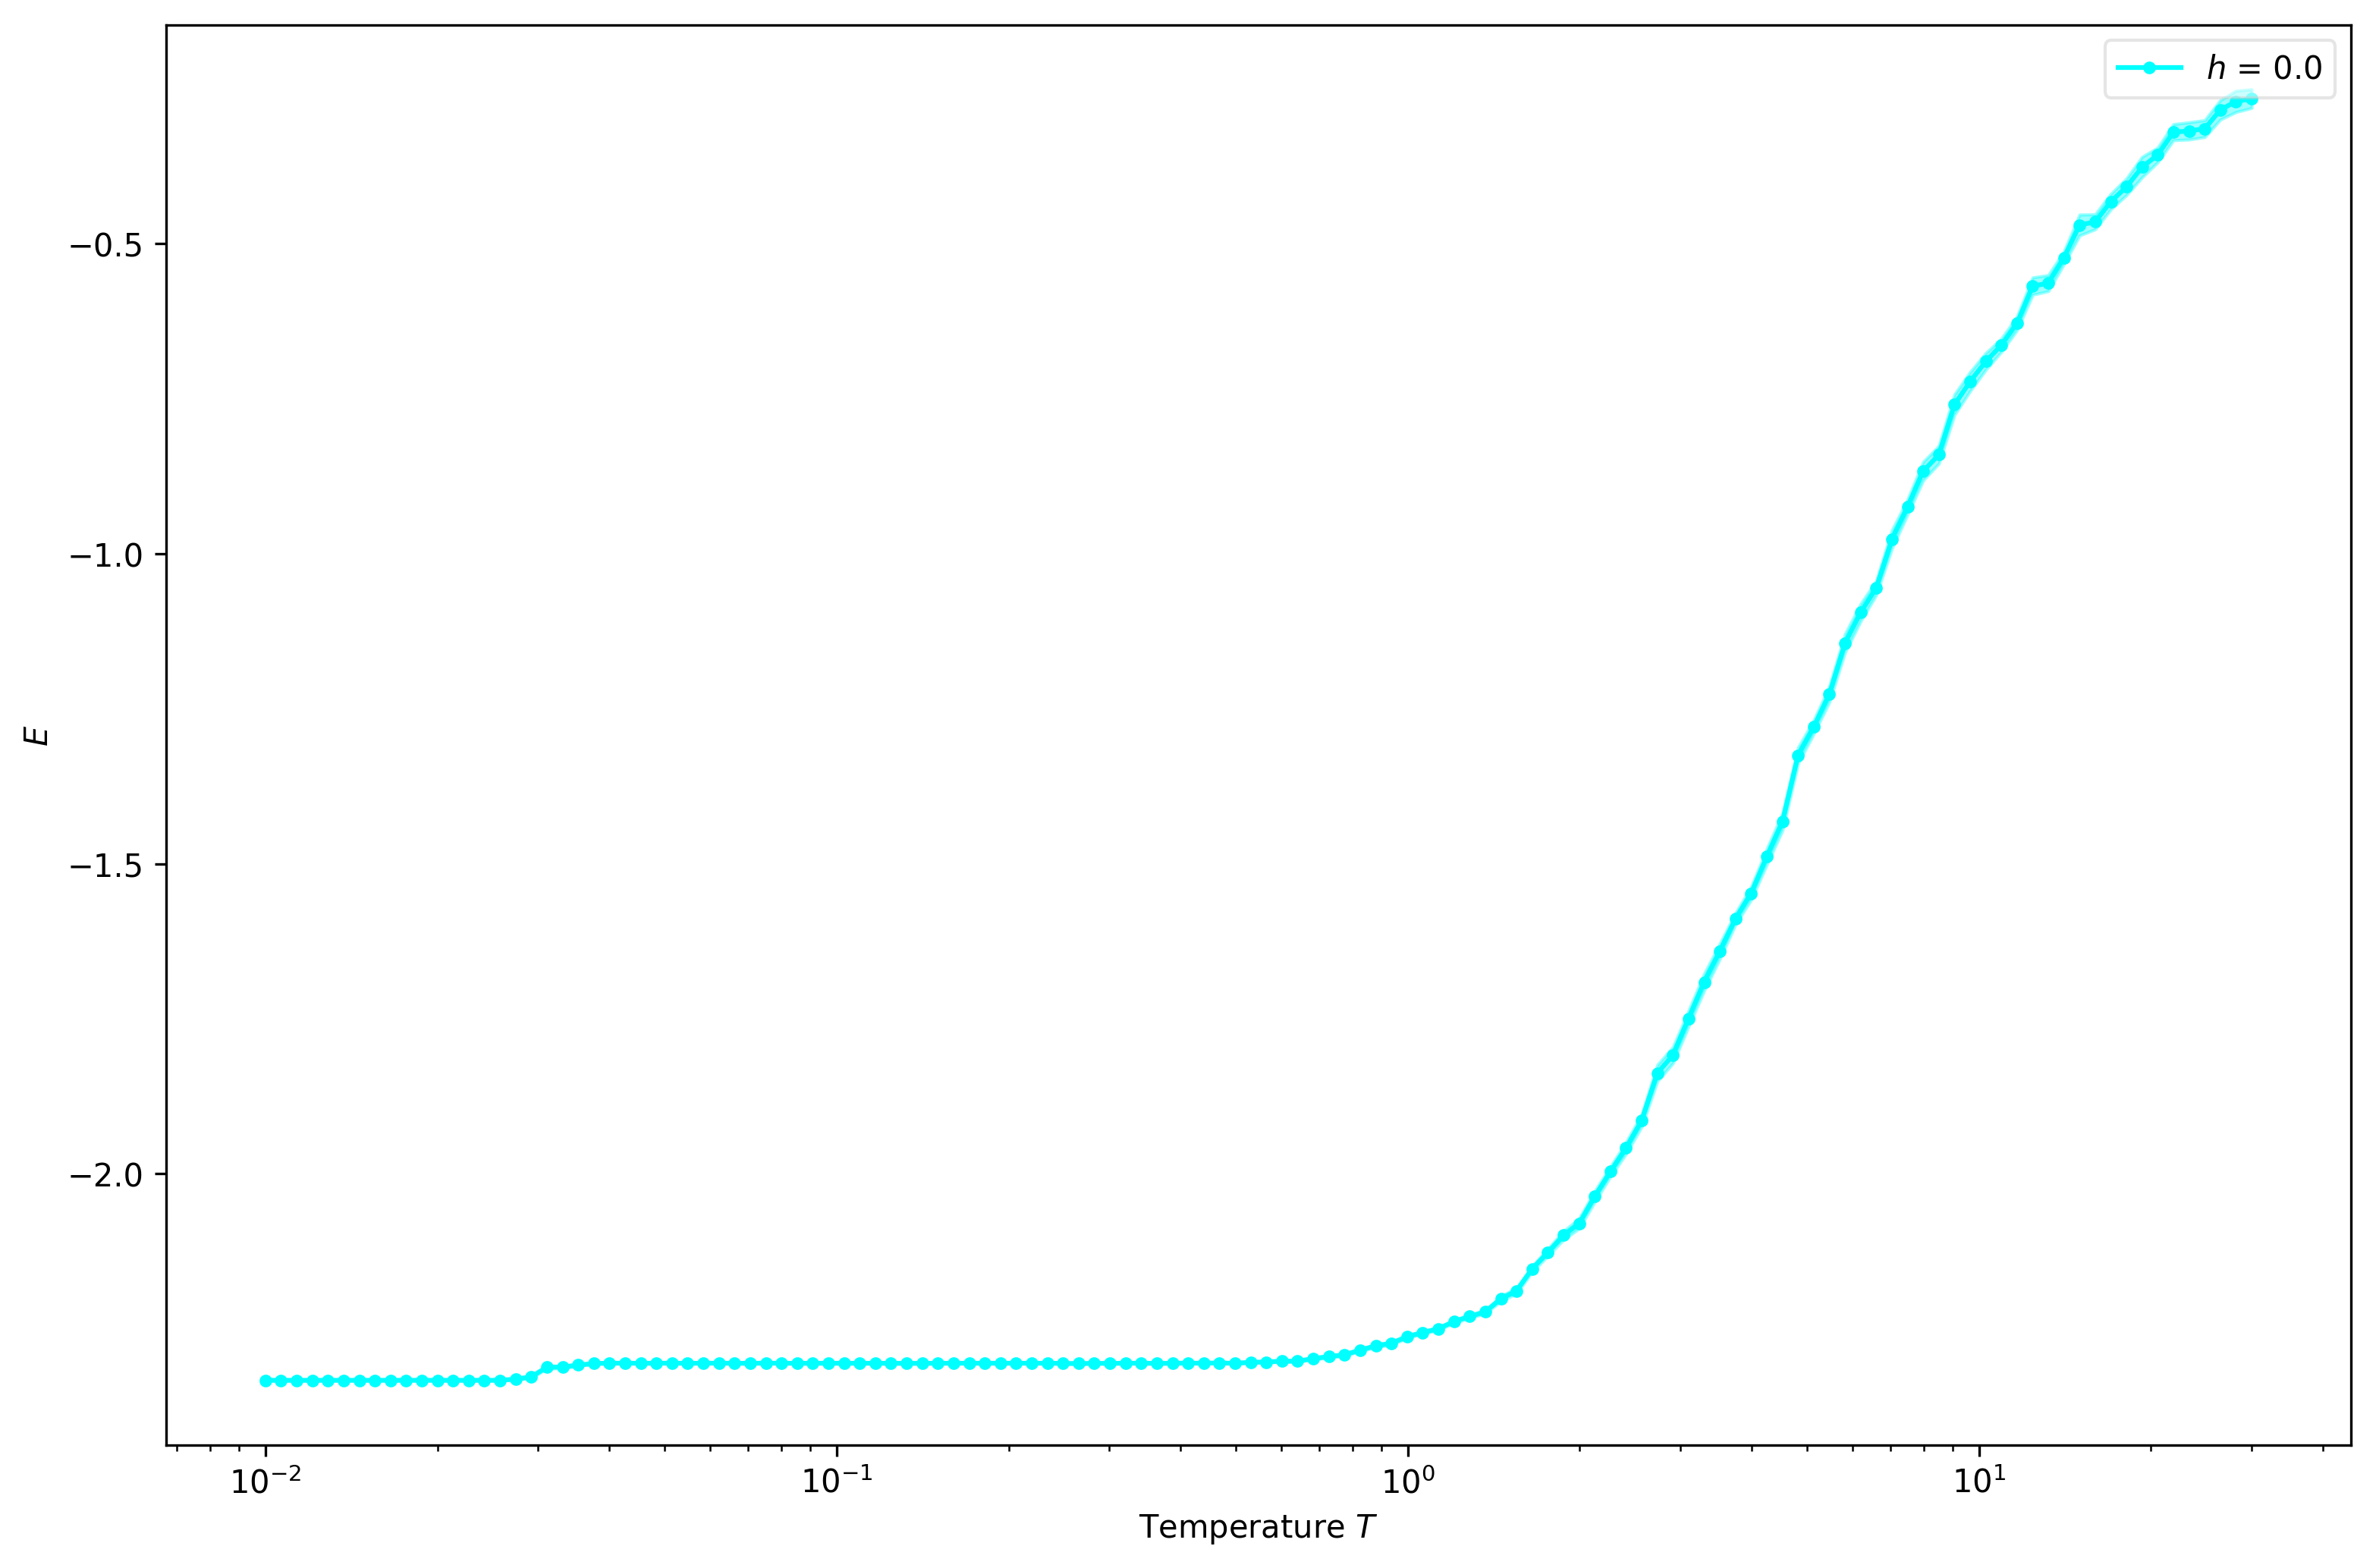

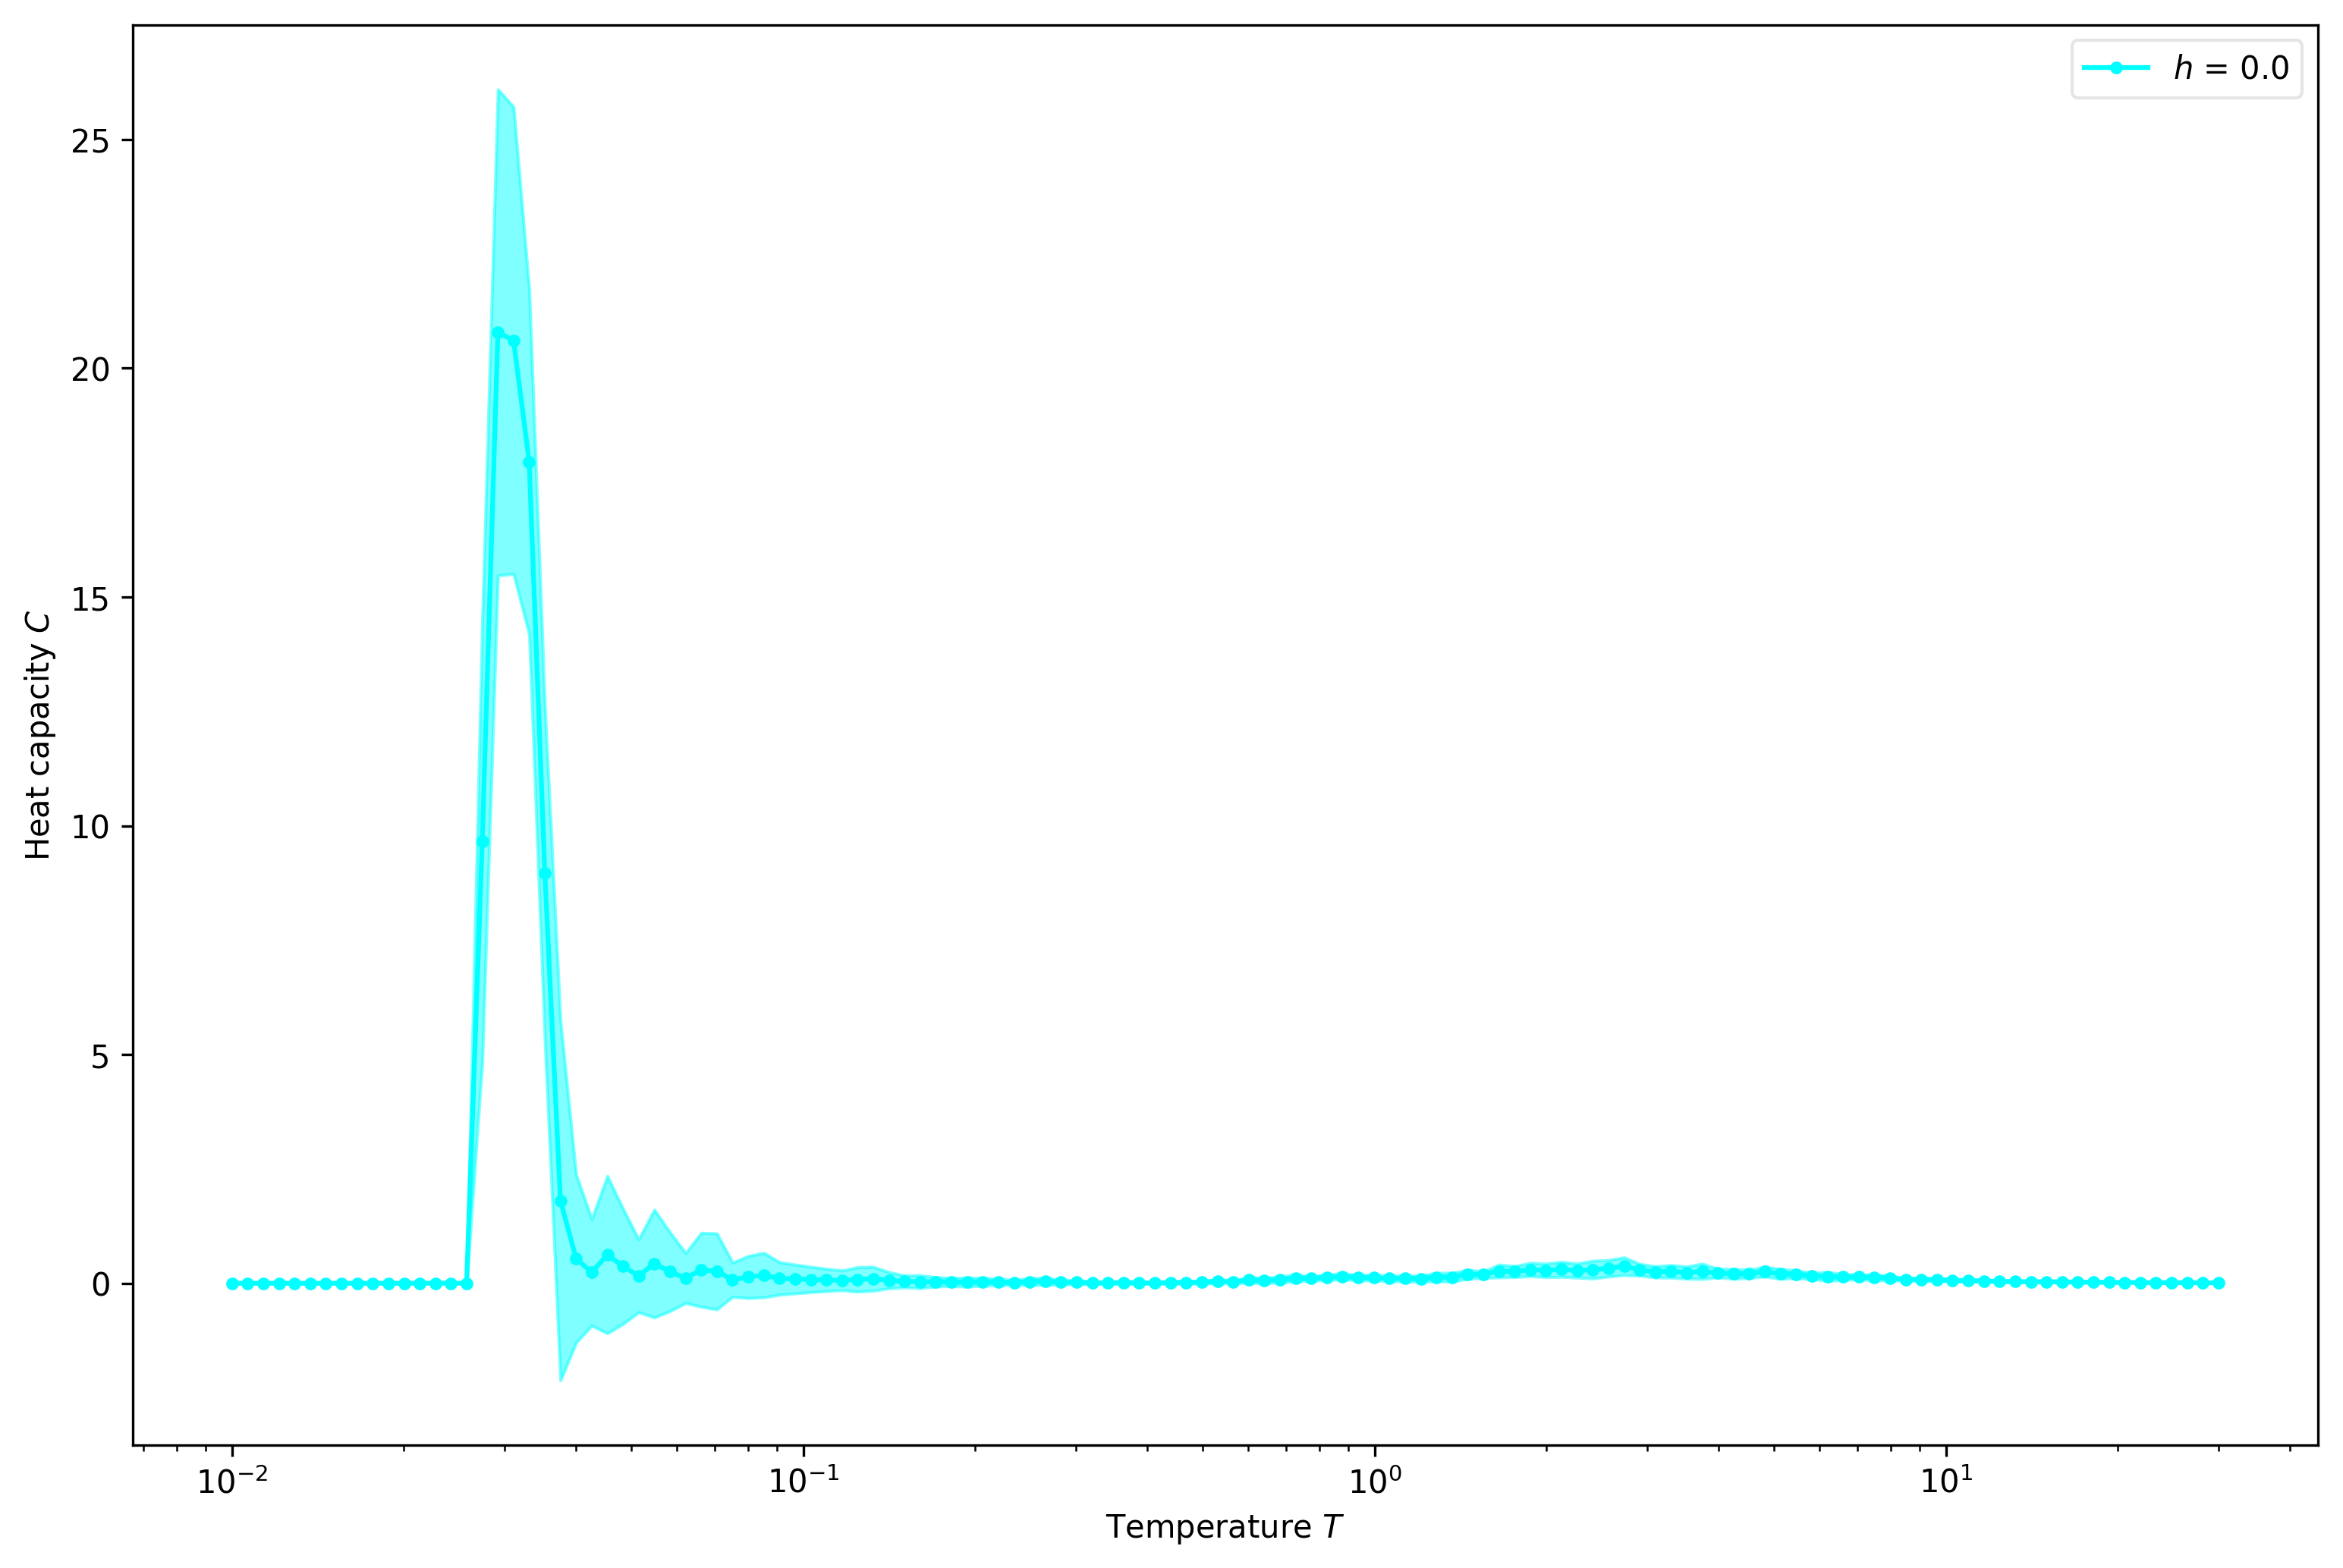

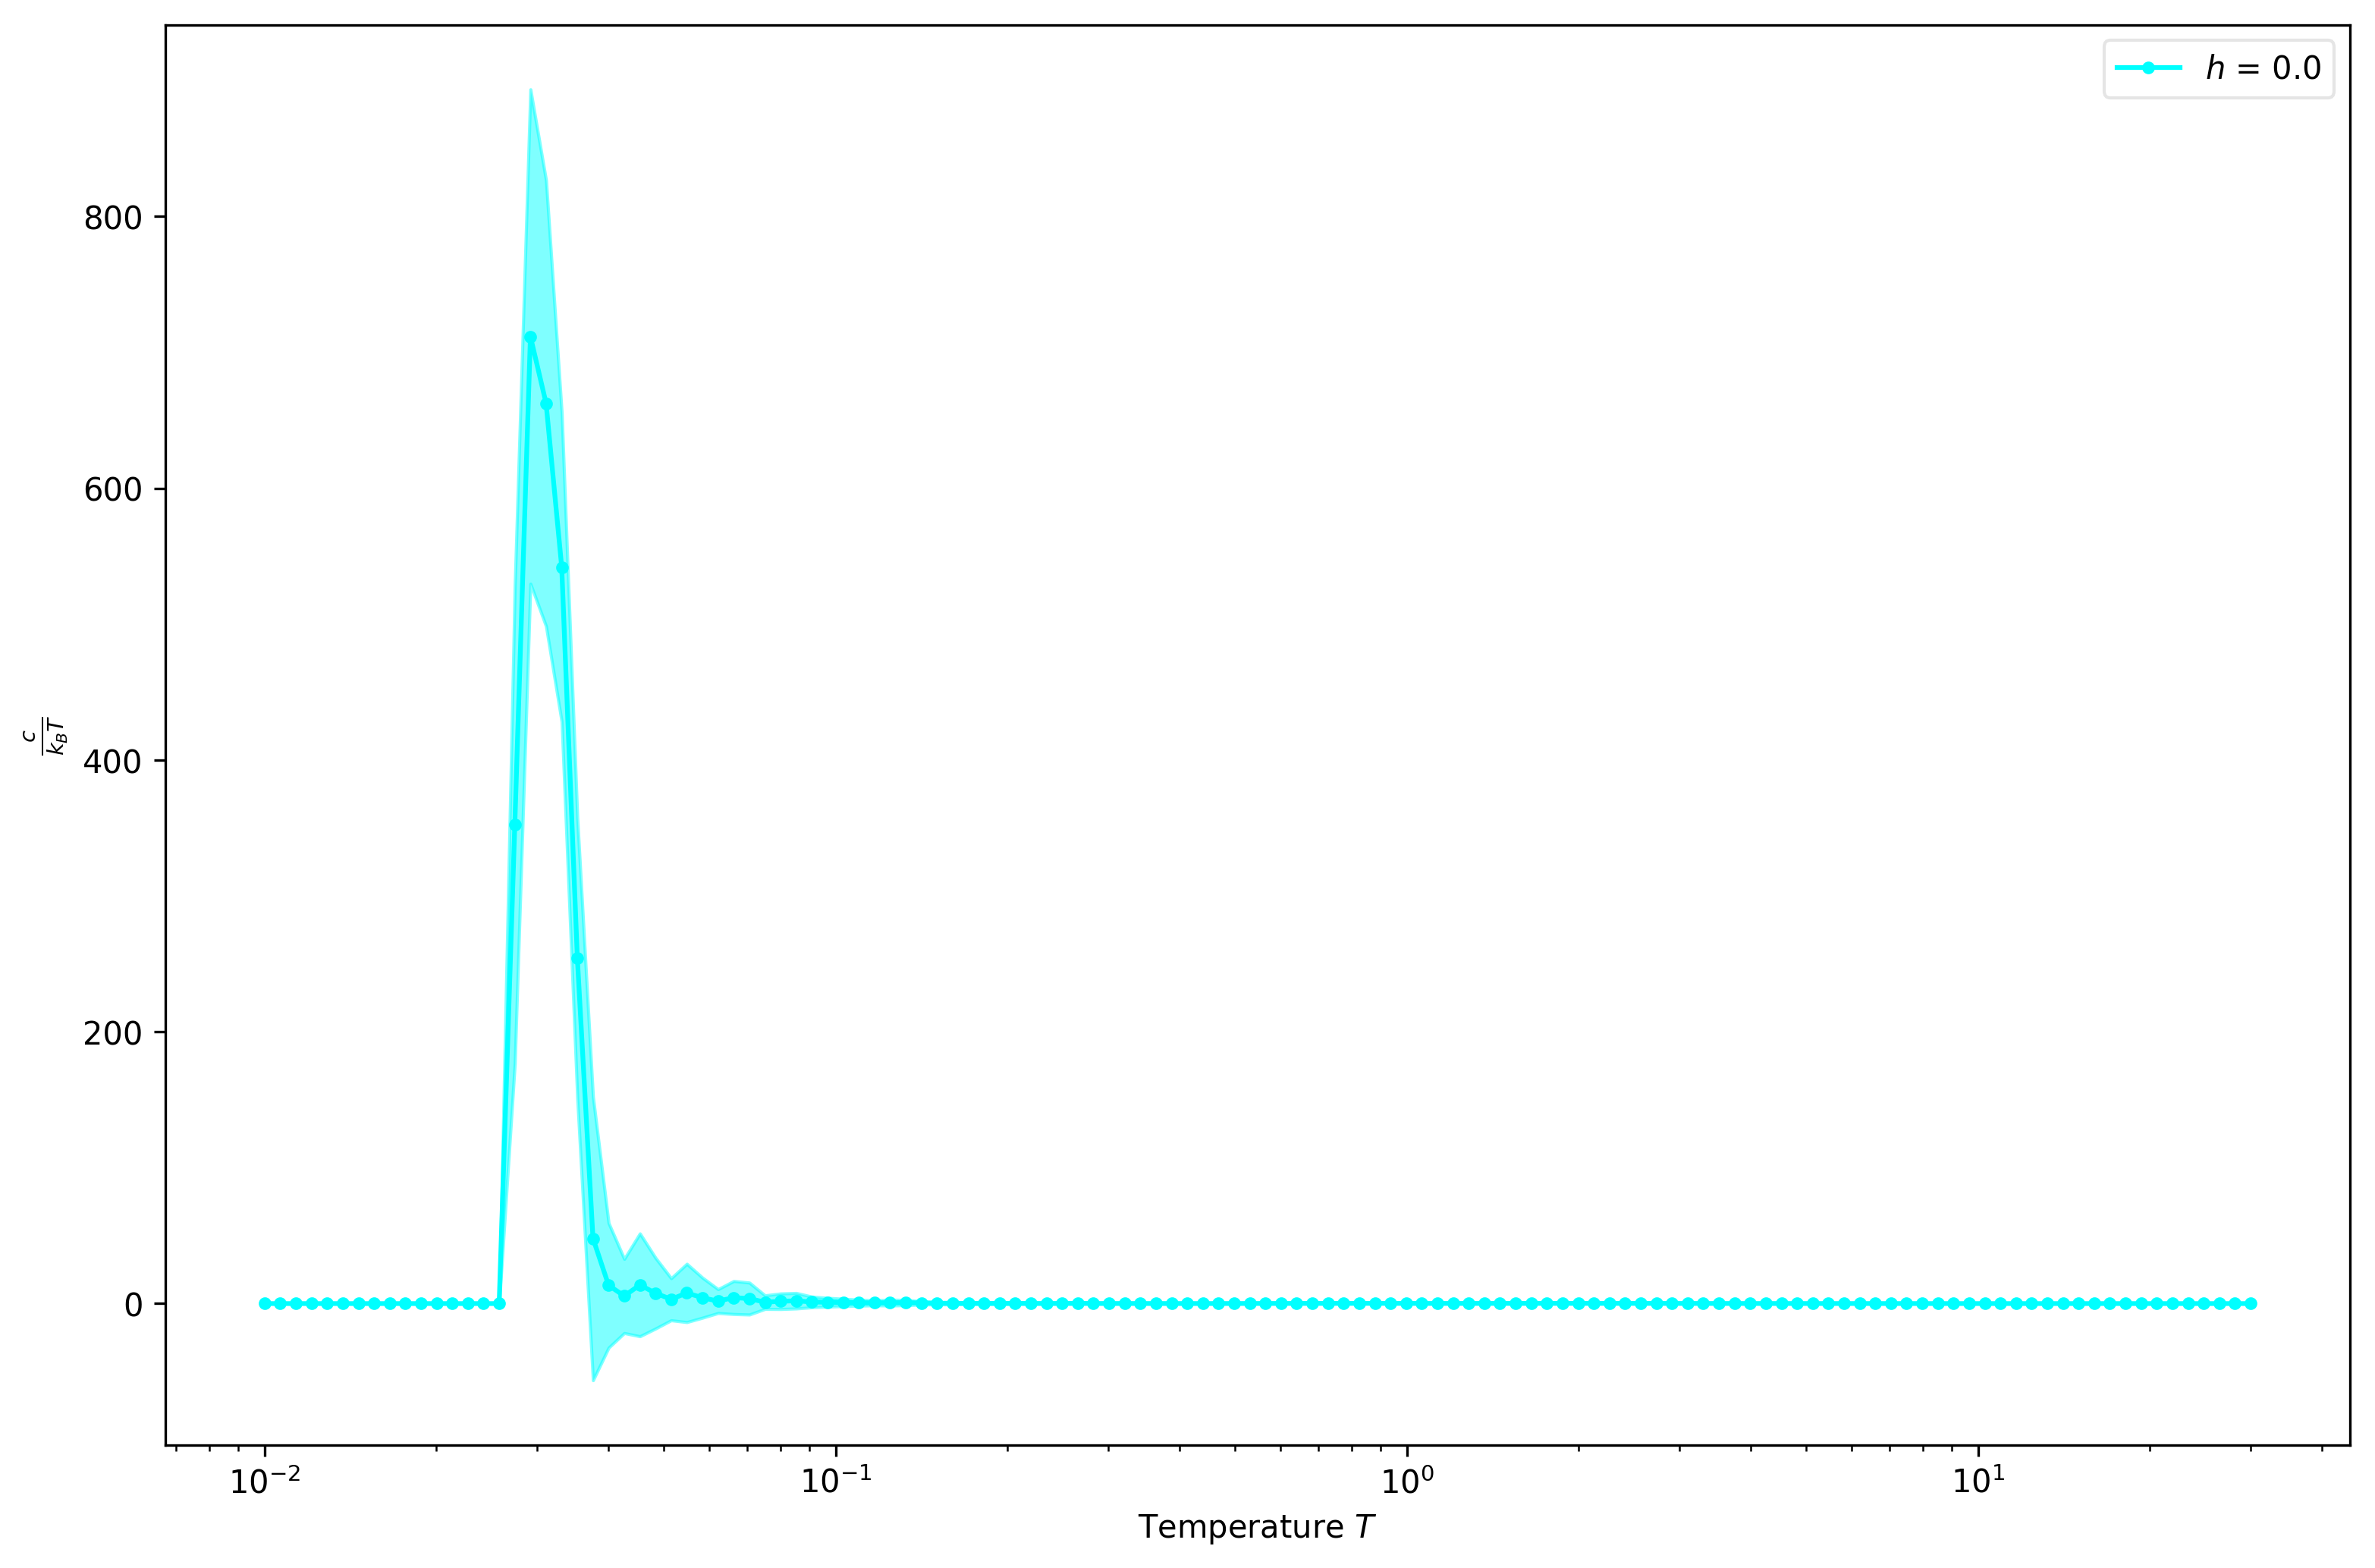

In [16]:
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': True}
af.BasicPlotsE(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanE, t_h_MeanEsq, t_h_varMeanE,
                t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, **kw)
plt.show()

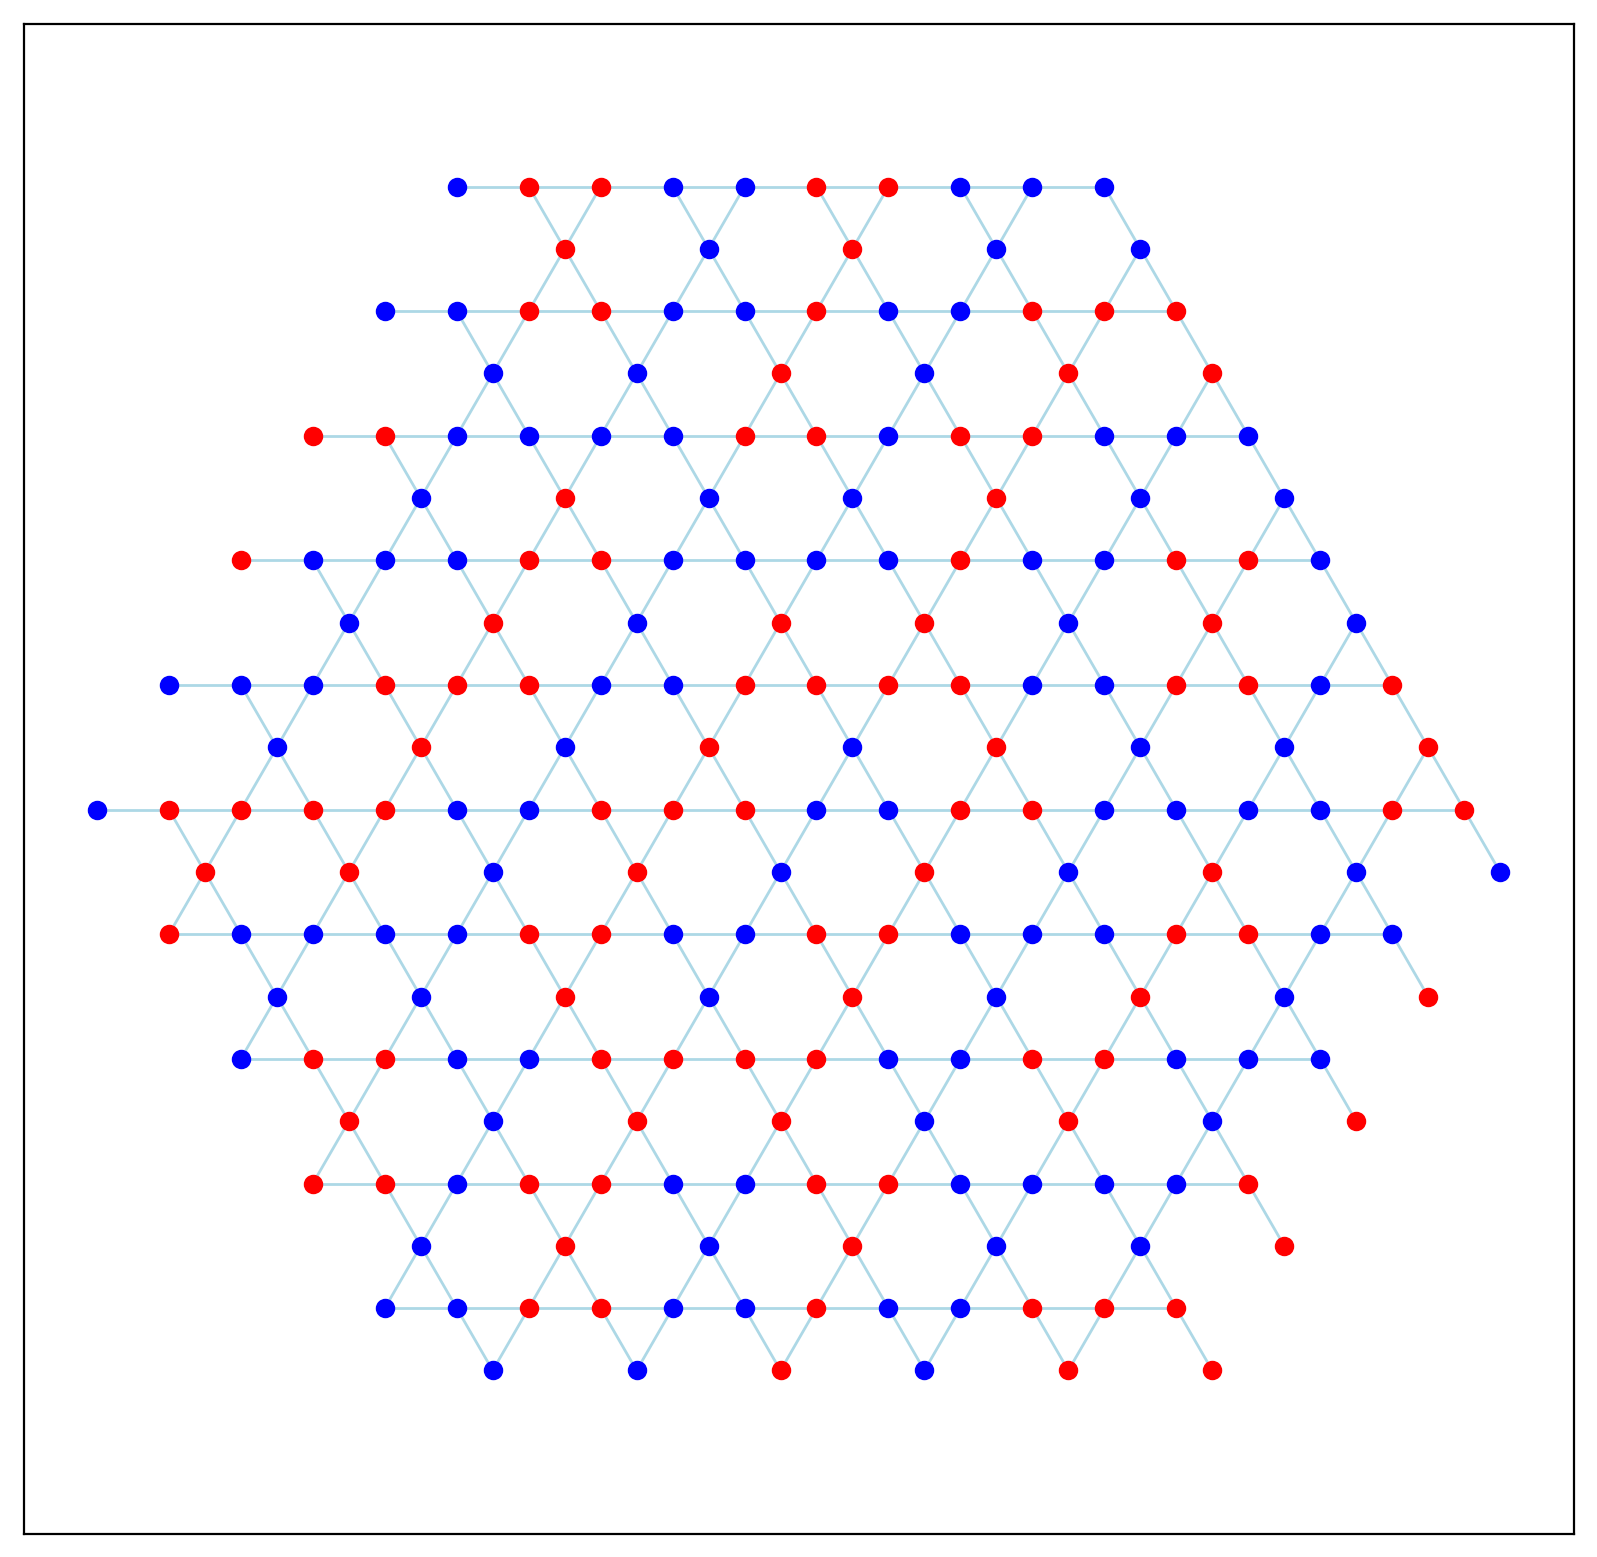

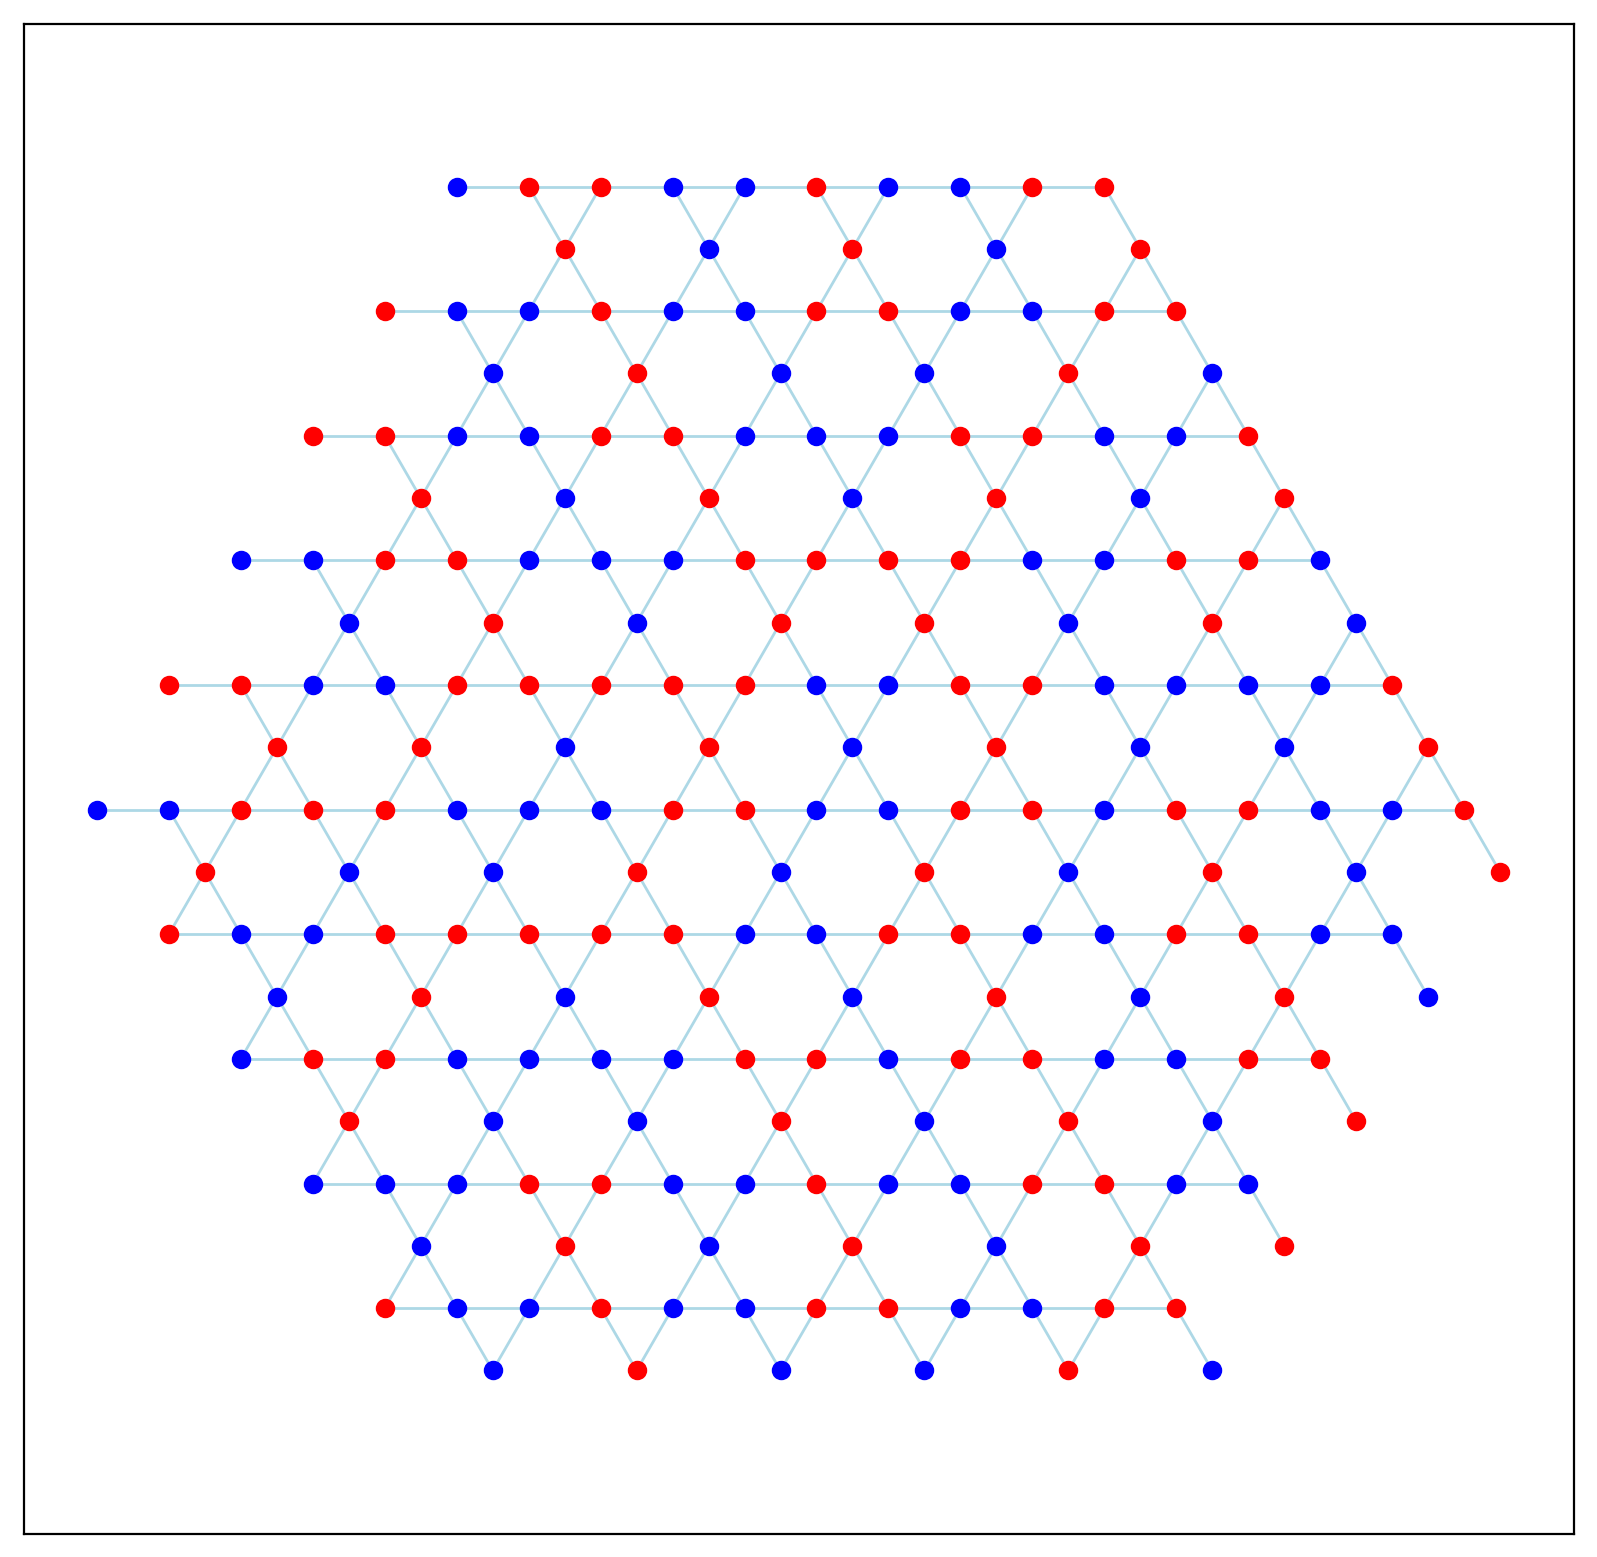

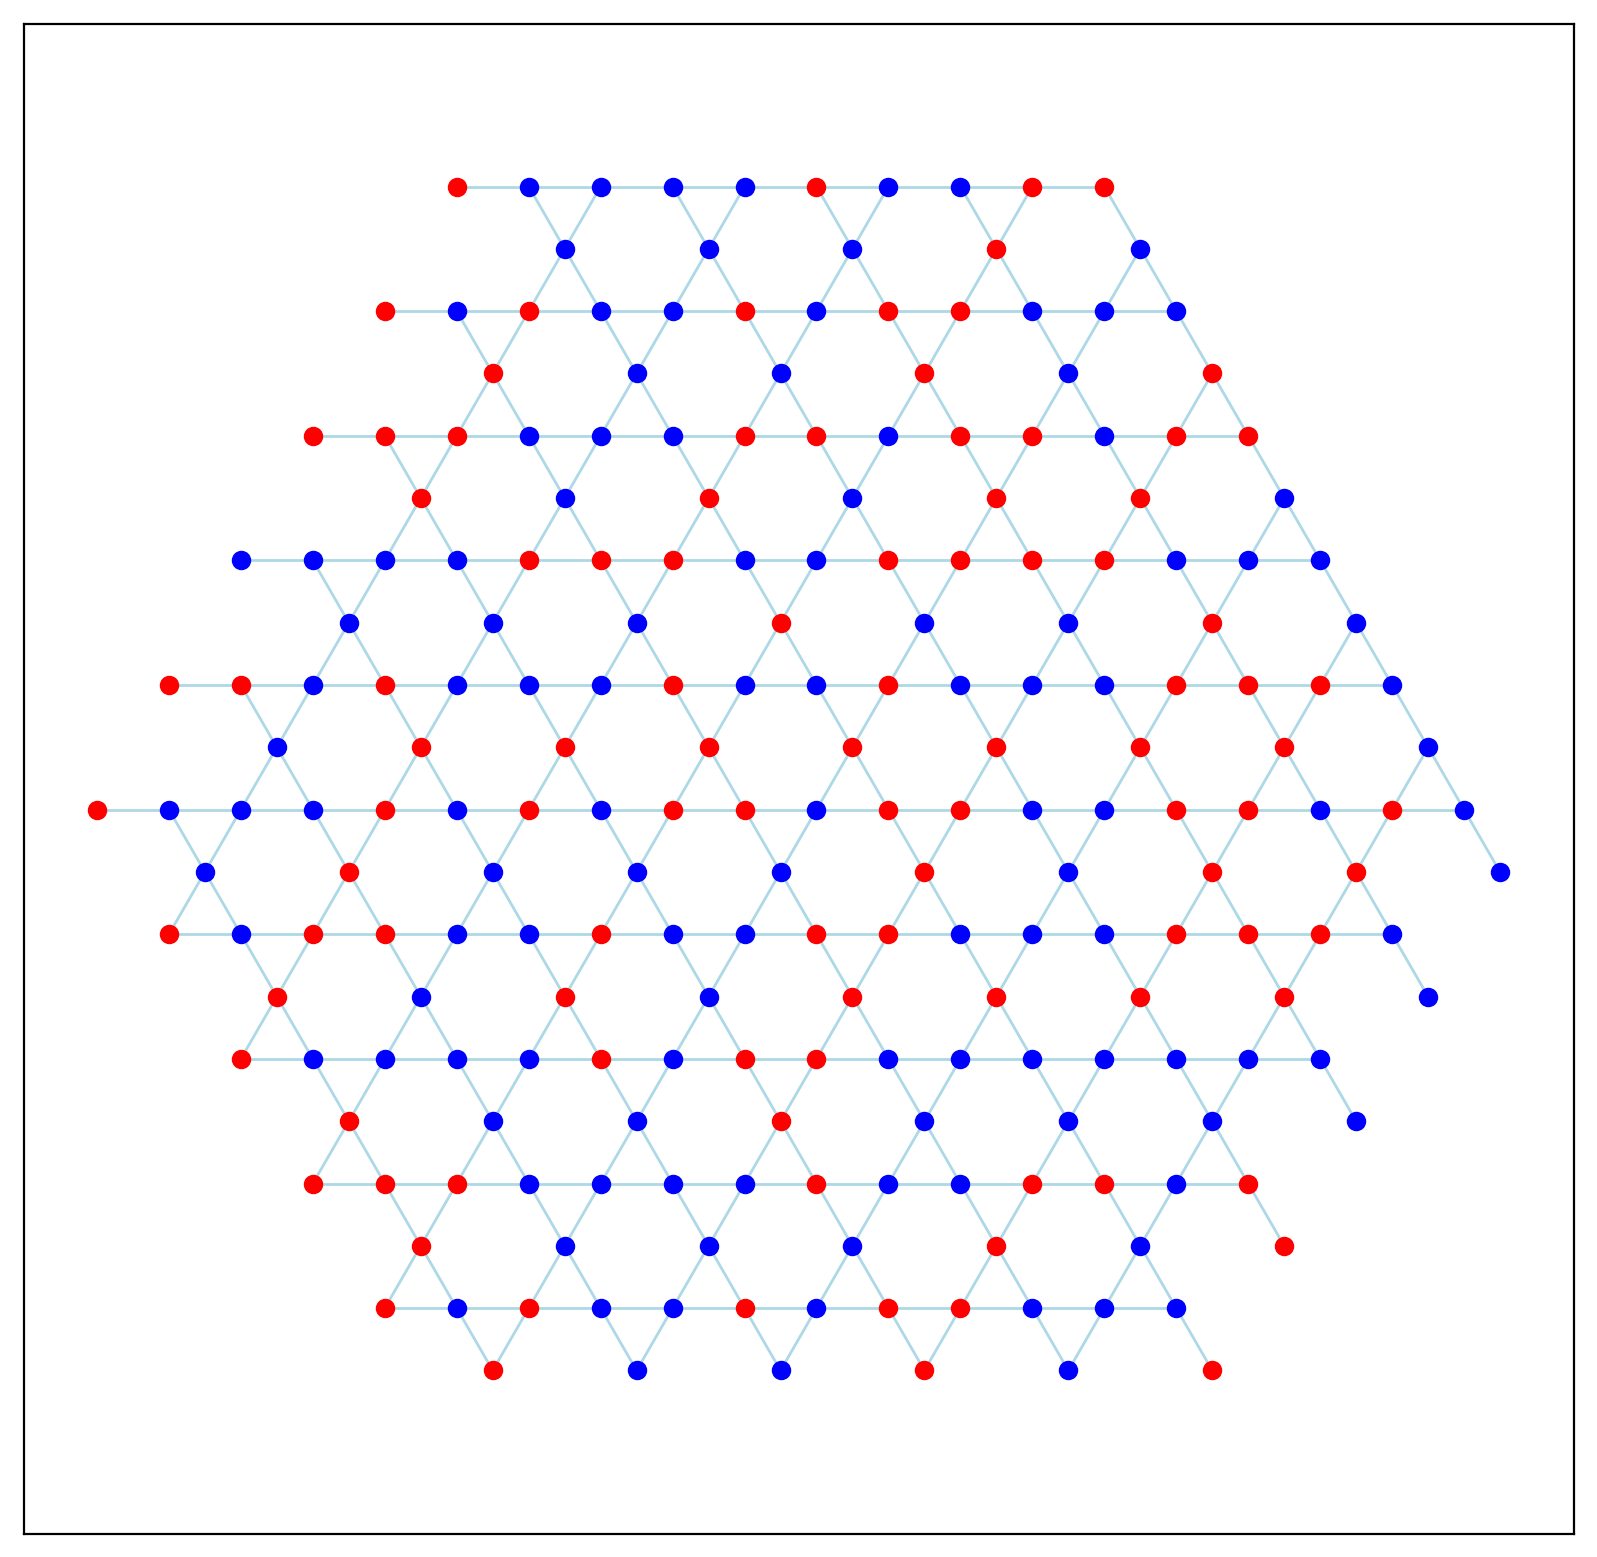

In [17]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_spinstates, t_states] = \
 af.LoadStates(foldername, filenamelist, **kw)
plt.figure(dpi=200, figsize=(10,10))
plt.axis('equal')
(s_ijl, ijl_s) = kdraw.createspinsitetable(L[0])
kdraw.plot_kag_spinstate(np.array(t_spinstates[0][0]), ijl_s, L[0], 2, 'lightblue', 'blue', 'red', linewidth = 1)
plt.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False)
plt.show()
plt.figure(dpi=200, figsize=(10,10))
plt.axis('equal')
(s_ijl, ijl_s) = kdraw.createspinsitetable(L[0])
kdraw.plot_kag_spinstate(np.array(t_spinstates[0][1]), ijl_s, L[0], 2, 'lightblue', 'blue', 'red', linewidth = 1)
plt.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False)
plt.show()
plt.figure(dpi=200, figsize=(10,10))
plt.axis('equal')
(s_ijl, ijl_s) = kdraw.createspinsitetable(L[0])
kdraw.plot_kag_spinstate(np.array(t_spinstates[0][10]), ijl_s, L[0], 4, 'lightblue', 'blue', 'red', linewidth = 1)
plt.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False)
plt.show()

<Figure size 432x288 with 0 Axes>

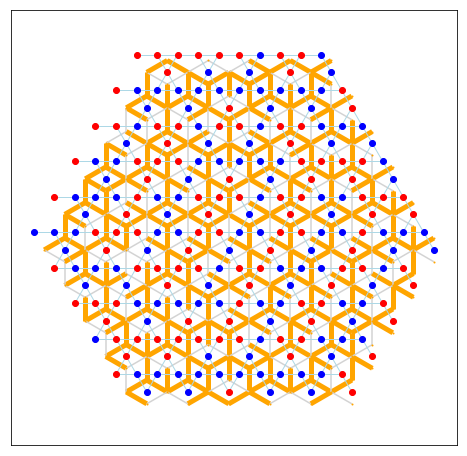

In [21]:
n = 0
[d_ijl, ijl_d, s_ijl, ijl_s, d_2s, s2_d,
 d_nd, d_vd, d_wn, sidlist, didlist,
 c_ijl, ijl_c, c2s, csign] = dw.latticeinit(L[n])

idstate = 2
plt.figure()
kdraw.plotstate(idstate, L[n], d_ijl, ijl_s, sidlist, didlist, s2_d,
               t_states[n], t_spinstates[n],dim_node_color = 'orange',
                dim_color = "orange", no_dim_color = 'lightgrey')
plt.savefig("./" + foldername + "/TestState{0}.png".format(idstate))
plt.show()